# Reinforcement Learning Model

In [18]:
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from fractions import Fraction

Preprocessing data for later use

In [19]:
# ==== PREPROCESSING ====
def preprocess(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)

    return img_rgb, mask[..., np.newaxis]

def load_dataset(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    X, Y = [], []

    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if os.path.exists(mask_path):
            img, mask = preprocess(image_path, mask_path)
            X.append(img)
            Y.append(mask)

    return np.array(X), np.array(Y)

## Defining Constants and Useful Functions##

In [20]:
IMG_SIZE = 224 # resize all of our images to 128 like with the benchmark u-net, suraj: changed to 224 from 128, starting point should be size of image
NUM_ACTIONS = 9
HISTORY_SIZE = 10 #
STATE_DIM = 4096 + NUM_ACTIONS * HISTORY_SIZE
#Changes max steps from 20 to 200
MAX_STEPS = 200
EXPERIENCE_SAMPLE_SIZE = 20
MAX_EXPERIENCE_SIZE = 1000
GAMMA = 0.1

In [21]:
@tf.function(reduce_retracing=True)
def compute_iou_tf(boxA, boxB):
    # boxA, boxB: shape (4,)
    xA = tf.maximum(boxA[0], boxB[0])
    yA = tf.maximum(boxA[1], boxB[1])
    xB = tf.minimum(boxA[2], boxB[2])
    yB = tf.minimum(boxA[3], boxB[3])
    inter = tf.maximum(0.0, xB - xA) * tf.maximum(0.0, yB - yA)
    areaA = tf.maximum(1.0, (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    areaB = tf.maximum(1.0, (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    union = areaA + areaB - inter + 1e-6
    return inter / union

def get_geometric_features(box, img_size, gt_box=None):
    # box: tf.Tensor shape (4,)
    x1, y1, x2, y2 = tf.unstack(box)
    norm_box = [x1 / img_size, y1 / img_size, x2 / img_size, y2 / img_size]
    area = tf.maximum(1.0, (x2 - x1) * (y2 - y1))
    norm_area = area / tf.cast(img_size * img_size, tf.float32)
    w = tf.maximum(1.0, x2 - x1)
    h = tf.maximum(1.0, y2 - y1)
    aspect_ratio = w / h
    iou = tf.constant(-1.0, dtype=tf.float32)
    if gt_box is not None:
        iou = compute_iou_tf(box, gt_box)
    return tf.stack(norm_box + [norm_area, aspect_ratio, iou])

@tf.function(reduce_retracing=True)
def extract_feature_tf(image, history, feature_extractor, box, img_size, gt_box=None):
    image = tf.image.resize(image, [img_size, img_size])
    image.set_shape([img_size, img_size, 3])
    image = tf.expand_dims(image, axis=0)

    history_onehot = tf.one_hot(history, depth=NUM_ACTIONS, dtype=tf.float32)
    history_flat = tf.reshape(history_onehot, [-1])

    features = feature_extractor(image)
    features_flat = tf.reshape(features, [-1])

    box_tf = tf.convert_to_tensor(box, dtype=tf.float32)
    gt_box_tf = tf.convert_to_tensor(gt_box, dtype=tf.float32) if gt_box is not None else None
    geo = get_geometric_features(box_tf, img_size, gt_box_tf)

    return tf.concat([features_flat, geo, history_flat], axis=0)



def compute_q(feature, model):
    return model.predict(feature, verbose=0).flatten()

def compute_mask(action, box):
  # changing from 0.1 to 0.2(alpha)
    delta_w = 0.2 * (box[2] - box[0])
    delta_h = 0.2 * (box[3] - box[1])
    x1, y1, x2, y2 = box

    if action == 0:  # move right
        x1 += delta_w
        x2 += delta_w
    elif action == 1:  # move left
        x1 -= delta_w
        x2 -= delta_w
    elif action == 2:  # move up
        y1 -= delta_h
        y2 -= delta_h
    elif action == 3:  # move down
        y1 += delta_h
        y2 += delta_h
    elif action == 4:  # zoom in (proportional)
        x1 += delta_w
        x2 -= delta_w
        y1 += delta_h
        y2 -= delta_h
    elif action == 5:  # zoom out (proportional)
        x1 -= delta_w
        x2 += delta_w
        y1 -= delta_h
        y2 += delta_h
    elif action == 6:  # vertical zoom in (squish height)
        y1 += delta_h
        y2 -= delta_h
    elif action == 7:  # horizontal zoom in (squish width)
        x1 += delta_w
        x2 -= delta_w

    # clip box to valid image bounds
    x1 = max(0, min(IMG_SIZE, x1))
    x2 = max(0, min(IMG_SIZE, x2))
    y1 = max(0, min(IMG_SIZE, y1))
    y2 = max(0, min(IMG_SIZE, y2))

    # enforce correct box ordering
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return [x1, y1, x2, y2]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / float(areaA + areaB - inter + 1e-6)

def crop_image(img, box):
    x1, y1, x2, y2 = map(int, box)
    cropped = img[y1:y2, x1:x2]
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE)) if cropped.size else np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

## Reward Structures

In [71]:
"""
This is a section on rewards. Currently we define 3 different functions:
binary -
IoU difference -
IoU penalty area -

each of the these take in the inputs action, gt, box, and end.
"""

def reward_binary(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt)
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.1 else -3
    else:
        reward = 1 if new_iou > old_iou else -1
    return reward

def paus_reward_iou_diff(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt)
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        
        reward = new_iou - old_iou
    return reward

def reward_iou_diff(action, gt, box, end=False, timed_out=False):
    gt = np.asarray(gt)
    if gt.ndim == 1:
        if gt.size == IMG_SIZE * IMG_SIZE:
            gt = gt.reshape((IMG_SIZE, IMG_SIZE))
            mask_is_valid = True
        else:
            mask_is_valid = False
    else:
        mask_is_valid = True
    new_box = compute_mask(action, box)
    new_iou = compute_iou(new_box, gt)
    old_iou = compute_iou(box, gt)
    diff = new_iou - old_iou
    box_area = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])
    norm_area = box_area / (IMG_SIZE * IMG_SIZE)
    reward = 0.0

    # Compute box center and mask centroid if mask is valid
    box_cx = (new_box[0] + new_box[2]) / 2
    box_cy = (new_box[1] + new_box[3]) / 2
    if mask_is_valid:
        mask_indices = np.argwhere(gt > 0.5)
        if len(mask_indices) > 0:
            mean_indices = mask_indices.mean(axis=0)
            if mean_indices.shape[0] == 2:
                mask_cy, mask_cx = mean_indices
                prev_box_cx = (box[0] + box[2]) / 2
                prev_box_cy = (box[1] + box[3]) / 2
                prev_dist = np.sqrt((prev_box_cx - mask_cx) ** 2 + (prev_box_cy - mask_cy) ** 2)
                new_dist = np.sqrt((box_cx - mask_cx) ** 2 + (box_cy - mask_cy) ** 2)
                # Reward for reducing distance to mask centroid
                reward += (prev_dist - new_dist) * 0.1
                # Penalty if box stays far from centroid and IoU is low
                if new_dist > IMG_SIZE * 0.2 and new_iou < 0.2:
                    reward -= 0.2
                # Strong penalty for default/centered box with low IoU
                if abs(box_cx - IMG_SIZE/2) < IMG_SIZE*0.1 and abs(box_cy - IMG_SIZE/2) < IMG_SIZE*0.1 and new_iou < 0.2:
                    reward -= 0.5

    if diff > 0:
        reward += diff * 20
        if diff > 0.05:
            reward += 5
        if new_iou > 0.5:
            reward += 8  # much higher bonus
    elif diff == 0:
        reward -= 0.1  # harsher stagnation penalty
    else:
        reward += diff * 5

    # Small reward for being close to the mask
    if new_iou > 0.3:
        reward += 0.2

    # Larger penalty for large box (discourage covering whole image)
    if norm_area > 0.5 and new_iou < 0.3:
        reward -= 1.0

    # Edge penalty
    if ((new_box[0] == 0 or new_box[1] == 0 or new_box[2] == IMG_SIZE or new_box[3] == IMG_SIZE) and new_iou < 0.3):
        reward -= 0.3

    if end and new_iou > 0.5:
        reward += 8
    if timed_out:
        reward -= 1

    return reward



def reward_iou_area_penalty(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    new_iou = compute_iou(new_box, gt)
    area = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])
    norm_area = area / (IMG_SIZE * IMG_SIZE)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        reward = new_iou - 0.1 * norm_area
    return reward

def reward_focus_area(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    iou = compute_iou(new_box, gt)

    # Dimensions of current box
    box_w = new_box[2] - new_box[0]
    box_h = new_box[3] - new_box[1]
    full_area = IMG_SIZE * IMG_SIZE

    # Prevent division by zero or nonsense
    if box_w <= 0 or box_h <= 0:
        return -1

    box_area = box_w * box_h

    # If box covers entire image (initial state), give 0 reward
    if box_area >= full_area * 0.99:  # Added small tolerance for floating point
        return 0.0

    # How many times this box could fit in the full image (using float division)
    fit_multiplier = full_area / box_area

    reward = iou * fit_multiplier

    if end:
        if timed_out:
            return 0
        else:
            return 3 if iou > 0.6 else -3

    return reward

def reward_iou_diff_with_area_ar_penalty(
    action, gt, box, end=False, timed_out=False, IMG_SIZE=224,
    lambda_area=0, lambda_ar=0
):
    new_box = compute_mask(action, box)
    new_iou = compute_iou(new_box, gt)
    old_iou = compute_iou(box, gt)

    # Box area and aspect ratio
    box_w = max(1, new_box[2] - new_box[0])
    box_h = max(1, new_box[3] - new_box[1])
    box_area = box_w * box_h
    box_ar = box_w / box_h

    # Mask area and aspect ratio (robust to 2D/3D masks)
    gt = np.array(gt)
    if gt.ndim == 3:
        # If mask has a singleton channel or is RGB, squeeze or take first channel
        if gt.shape[2] == 1:
            gt_proc = np.squeeze(gt, axis=2)
        else:
            gt_proc = gt[..., 0]
    else:
        gt_proc = gt

    coords = np.where(gt_proc > 0)
    if len(coords) >= 2 and len(coords[0]) > 0 and len(coords[1]) > 0:
        ys, xs = coords
        mask_w = xs.max() - xs.min() + 1
        mask_h = ys.max() - ys.min() + 1
        mask_area = mask_w * mask_h
        mask_ar = mask_w / mask_h
    else:
        mask_area = 1.0
        mask_ar = 1.0  # fallback

    # Area penalty (log ratio, symmetric)
    area_ratio = box_area / (mask_area + 1e-6)
    area_penalty = lambda_area * abs(np.log(area_ratio))

    # Aspect ratio penalty (log difference, symmetric)
    ar_diff = abs(np.log(box_ar) - np.log(mask_ar))
    ar_penalty = lambda_ar * ar_diff

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        reward = 50 * (new_iou - old_iou)

    return reward


In [63]:
def random_initial_box(img_size=224, min_size=30, max_size=100):
    # Choose random width and height
    w = random.randint(min_size, max_size)
    h = random.randint(min_size, max_size)
    # Choose random top-left corner so box fits in image
    x1 = random.randint(0, img_size - w)
    y1 = random.randint(0, img_size - h)
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

In [64]:
# ==== MODEL + AGENT ====
from tensorflow.keras.layers import Dropout
def create_q_model():
    model = Sequential([
      Dense(1024, activation='relu', input_shape=(STATE_DIM,)),
      Dropout(0.3),
      Dense(1024, activation='relu'),
      Dropout(0.3),
      Dense(NUM_ACTIONS),
    ])
    #added accuracy
    #model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
    model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='mse',  metrics = ['accuracy'])
    return model

class QAgent:
    def __init__(self, model, epsilon=1.0):
        self.model = model
        # Create the target network
        self.target_model = tf.keras.models.clone_model(model)
        self.target_model.set_weights(model.get_weights())
        self.epsilon = epsilon
        self.gamma = 0.99
        self.memory = []  
        self.train_steps = 0
        self.update_target_steps = 100  # Update target network every 100 training steps

    def remember(self, transition):
        self.memory.append(transition)
        if len(self.memory) > 10000:  # optional memory cap
            self.memory.pop(0)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(NUM_ACTIONS)
        q_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Debug: Print sampled batch
        print("Sampled batch states (first 5 per state):", [s.numpy()[:5] for s in states])
        print("Sampled batch actions:", actions)
        print("Sampled batch rewards:", rewards)

        # Use tf.stack instead of np.array to ensure proper tensor shape
        states = tf.stack(states)
        next_states = tf.stack(next_states)

        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        target_qs = q_values.copy()

        for i in range(batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_q_values[i])
            target_qs[i][actions[i]] = target

        loss = self.model.train_on_batch(states, target_qs)
        self.train_steps += 1
        if self.train_steps % self.update_target_steps == 0:
            self.update_target_network()
        print("Training loss:", loss)



In [65]:
def train_dqn(X_train, Y_train, vgg16_model, reward_fn, epochs=10, epsilon=1.0):
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.output)
    model = create_q_model()  # should return a compiled model with input shape (STATE_DIM,)
    agent = QAgent(model, epsilon=epsilon)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_rewards = []
        for i in range(len(X_train)):
            img, mask = X_train[i], Y_train[i]
            ys, xs = np.where(mask.squeeze() > 0)
            if len(xs) == 0 or len(ys) == 0:
                continue

            gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
            history = [-1] * HISTORY_SIZE
            current_box = random_initial_box(IMG_SIZE)

            img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
            history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
            box_tensor = tf.convert_to_tensor(current_box, dtype=tf.float32)
            gt_box_tensor = tf.convert_to_tensor(gt_box, dtype=tf.float32) if gt_box is not None else None
            state = extract_feature_tf(img_tensor, history_tensor, feature_extractor, box_tensor, IMG_SIZE, gt_box_tensor)

            # Debug: Print box and state
            #print(f"Current box: {current_box}")
            #print(f"State vector (first 10): {state.numpy()[:10]}")

            done, step = False, 0
            while not done:
                action = agent.select_action(state.numpy())
                #print(f"Step {step}: Action chosen = {action}")
                next_box = current_box if action == 8 else compute_mask(action, current_box)
                #print(f"Box after action: {next_box}")
                end = action == 8 or step >= MAX_STEPS
                timed_out = step >= MAX_STEPS and action != 8
                reward = reward_fn(action, gt_box, current_box, end=end, timed_out=timed_out)
                epoch_rewards.append(reward)

                # Debug: Print transition
                img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
                history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
                box_tensor = tf.convert_to_tensor(current_box, dtype=tf.float32)
                gt_box_tensor = tf.convert_to_tensor(gt_box, dtype=tf.float32) if gt_box is not None else None
                next_state = extract_feature_tf(img_tensor, history_tensor, feature_extractor, box_tensor, IMG_SIZE, gt_box_tensor)
                #print("Transition:", (state.numpy()[:5], action, reward, next_state.numpy()[:5], end))

                #if step % 100 == 0:
                    #print(f"Epoch {epoch+1}, Image {i}, Step {step}, Action {action}, Reward {reward:.4f}")

                history = history[1:] + [action]
                next_crop = crop_image(img, next_box).astype(np.float32)
                next_crop_tensor = tf.convert_to_tensor(next_crop, dtype=tf.float32)
                history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
                box_tensor = tf.convert_to_tensor(next_box, dtype=tf.float32)
                gt_box_tensor = tf.convert_to_tensor(gt_box, dtype=tf.float32) if gt_box is not None else None
                next_state = extract_feature_tf(next_crop_tensor, history_tensor, feature_extractor, box_tensor, IMG_SIZE, gt_box_tensor)

                agent.remember((state, action, reward, next_state, end))
                state = next_state
                current_box = next_box
                step += 1
                done = end

        # Print summary at end of epoch (outside image loop)
        if len(epoch_rewards) > 0:
            print(f"Epoch {epoch+1} reward stats: mean={np.mean(epoch_rewards):.4f}, min={np.min(epoch_rewards):.4f}, max={np.max(epoch_rewards):.4f}")
        else:
            print(f"Epoch {epoch+1}: No rewards collected (possibly all masks were empty or skipped).")

        agent.train(batch_size=8)
        #agent.epsilon = max(agent.epsilon * 0.98, 0.02)
        agent.epsilon = max(agent.epsilon * 0.995, 0.2)

    return agent.model

In [66]:
# ==== EVALUATION ====
def evaluate_model(model, X_test, Y_test, vgg16_model):
    # Use the same feature extractor as in training
    feature_extractor = tf.keras.Model(
        inputs=vgg16_model.input,
        outputs=vgg16_model.output
    )

    ious = []
    for i in range(len(X_test)):
        img = X_test[i].astype(np.float32)
        mask = Y_test[i]

        ys, xs = np.where(mask.squeeze() > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue

        gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
        history = [-1] * HISTORY_SIZE
        current_box = [0, 0, IMG_SIZE, IMG_SIZE]

        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
        # Use the new extract_feature_tf signature: (image, history, feature_extractor, box, img_size, gt_box)
        state = extract_feature_tf(img_tensor, history_tensor, feature_extractor, current_box, IMG_SIZE, gt_box)

        done, step = False, 0
        while not done:
            state_batched = tf.expand_dims(state, axis=0)
            q_values = model.predict(state_batched, verbose=0)[0]
            action = np.argmax(q_values)

            next_box = current_box if action == 8 else compute_mask(action, current_box)
            done = action == 8 or step >= MAX_STEPS
            history = history[1:] + [action]

            # Crop the image to the next box and get the new state
            next_crop = crop_image(img, next_box).astype(np.float32)
            next_crop_tensor = tf.convert_to_tensor(next_crop, dtype=tf.float32)
            history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
            state = extract_feature_tf(next_crop_tensor, history_tensor, feature_extractor, next_box, IMG_SIZE, gt_box)

            current_box = next_box
            step += 1

        iou = compute_iou(current_box, gt_box)
        ious.append(iou)
        print(f"Image {i}, Final IoU: {iou:.4f}")
        print("Q-values:", q_values)

    avg_iou = np.mean(ious)
    print(f"\nAverage IoU on test set: {avg_iou:.4f}")


Similar code to before evaluating binary overlap or not (i.e. we get a reward for having overlap with the ground truth).

In [27]:
def binary_overlap_score(model, image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    total = 0
    correct = 0

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if not os.path.exists(mask_path):
            continue  # skip unmatched files

        # Preprocess input and ground truth
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask_bin = (mask > 127).astype(np.uint8)

        # Predict
        pred = model.predict(np.expand_dims(img_rgb, axis=0))[0].squeeze().round().astype(np.uint8)

        # Check if there's any overlap
        overlap = np.logical_and(pred, mask_bin).any()

        total += 1
        if overlap:
            correct += 1

    print(f"Binary overlap score: {correct}/{total}")
    return f"{correct}/{total}", Fraction(correct, total)

## Data Augmentation

In [30]:
#print(model.predict(state, verbose=0)[0])
# Loading models
from tensorflow.keras.models import load_model

trained_model = load_model("dqn_mini_model_new_ioudiff_300.keras", compile=False)

In [31]:
def visualize_agent_prediction(model, vgg16_model, image_dir, mask_dir, img_size=224):
    import os
    import random
    import cv2
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"No mask found for {sample_file}. Skipping.")
        return

    # Load and normalize image
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

    # Load and process mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask_resized > 127).astype(np.uint8)

    # Feature extractor
    feature_extractor = vgg16_model

    # Get ground truth box for IoU/geometric features
    ys, xs = np.where(mask_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        print(f"Empty mask for {sample_file}. Skipping.")
        return
    gt_box = [int(np.min(xs)), int(np.min(ys)), int(np.max(xs)), int(np.max(ys))]

    # Inference loop
    history = [-1] * HISTORY_SIZE
    current_box = [0, 0, img_size, img_size]
    trajectory = [current_box.copy()]
    img_tensor = tf.convert_to_tensor(img_rgb, dtype=tf.float32)
    history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
    box_tensor = tf.convert_to_tensor(current_box, dtype=tf.float32)
    gt_box_tensor = tf.convert_to_tensor(gt_box, dtype=tf.float32)
    state = extract_feature_tf(img_tensor, history_tensor, feature_extractor, box_tensor, img_size, gt_box_tensor)

    done, step = False, 0
    while not done:
        action = np.argmax(model.predict(np.expand_dims(state.numpy(), axis=0), verbose=0)[0])
        next_box = current_box if action == 8 else compute_mask(action, current_box)
        done = action == 8 or step >= MAX_STEPS
        history = history[1:] + [action]
        history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
        box_tensor = tf.convert_to_tensor(next_box, dtype=tf.float32)
        state = extract_feature_tf(img_tensor, history_tensor, feature_extractor, box_tensor, img_size, gt_box_tensor)
        current_box = next_box
        trajectory.append(current_box.copy())
        step += 1

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    overlay = img_rgb.copy()
    overlay[mask_bin == 1] = [1.0, 0.0, 0.0]
    axs[1].imshow(overlay)
    axs[1].set_title('Ground Truth Mask Overlay')
    axs[1].axis('off')

    axs[2].imshow(img_rgb)
    for box in trajectory[:-1]:
        x1, y1, x2, y2 = map(int, box)
        axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           linewidth=1, edgecolor='blue', facecolor='none', alpha=0.3))
    x1, y1, x2, y2 = map(int, trajectory[-1])
    axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor='lime', facecolor='none', linestyle='--'))
    axs[2].set_title('RL Trajectory (Blue) + Final Box (Green)')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Example to generate augmented images
augmented_images = []
augmented_masks = []

for img, mask in zip(X_train, Y_train):
    img = img.reshape((1,) + img.shape)  # Add batch dim
    mask = mask.reshape((1,) + mask.shape)

    img_gen = augmenter.flow(img, batch_size=1)
    mask_gen = augmenter.flow(mask, batch_size=1)

    for _ in range(2):  # Add 2 augmented versions per image
        augmented_images.append(next(img_gen)[0])
        augmented_masks.append(next(mask_gen)[0])

# Combine with original
X_train_aug = np.concatenate([X_train, np.array(augmented_images)])
Y_train_aug = np.concatenate([Y_train, np.array(augmented_masks)])


In [ ]:
#X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
#X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg16.trainable = False
#trained_model = train_dqn(X_train_aug, Y_train_aug, vgg16, reward_fn = reward_iou_diff_with_area_ar_penalty, epochs=10, epsilon=1.0)
#trained_model.save("dqn_hemorrhage_model_area_ar_pen_001lambda_100e.h5")
#trained_model = train_dqn(X_train_aug, Y_train_aug, vgg16, reward_fn = reward_iou_diff_area, epochs=15, epsilon=1.0)
#trained_model.save("dqn_hemorrhage_model_diff_area_aug.h5")

In [ ]:
visualize_agent_prediction(trained_model, vgg16, 'hemorrhage_CT/images', 'hemorrhage_CT/masks')

In [ ]:
evaluate_model(trained_model, X_temp, Y_temp, vgg16)

In [13]:
def full_image_iou_score(image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    # Paths
    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"Mask not found for {sample_file}. Skipping.")
        return

    # Load and preprocess
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask > 127).astype(np.uint8)

    ys, xs = np.where(mask_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        print(f"No tumor in mask for {sample_file}.")
        return

    # Define ground truth box
    gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]

    # Define prediction as full image
    pred_box = [0, 0, img_size, img_size]

    # Compute IoU
    iou = compute_iou(pred_box, gt_box)
    print(f"Sample: {sample_file}")
    print(f"Ground Truth Box: {gt_box}")
    print(f"Predicted Full Image Box: {pred_box}")
    print(f"IoU: {iou:.4f}")
    return iou

full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks')

Sample: 084_20.jpg
Ground Truth Box: [34, 46, 43, 59]
Predicted Full Image Box: [0, 0, 128, 128]
IoU: 0.0071


0.007141113280814141

In [ ]:
vals = []
for _ in range(20):
    vals.append(full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks'))
print("average overall: ", np.mean(vals))

In [ ]:
# model_binary = tf.keras.models.load_model('dqn_mini_model.keras')
visualize_agent_prediction(model_binary, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')

In [ ]:
def visualize_pre_cnn_input(image_path, mask_path):
    # --- Load original image and mask ---
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if original is None or mask is None:
        print("Missing file.")
        return

    # Resize for CNN
    resized_image = cv2.resize(original, (224, 224))
    resized_mask = cv2.resize(mask, (224, 224))

    # Normalize + convert to RGB for consistency
    img_rgb = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    mask_bin = (mask > 127).astype(np.uint8)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    resized_mask_bin = (resized_mask > 127).astype(np.uint8)

    # Create overlays
    overlay_original = img_rgb.copy()
    overlay_original[mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    overlay_resized = resized_rgb.copy()
    overlay_resized[resized_mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(overlay_original)
    axs[1].set_title('Original + Mask Overlay')
    axs[2].imshow(resized_image, cmap='gray')
    axs[2].set_title('Resized for CNN (224×224)')
    axs[3].imshow(overlay_resized)
    axs[3].set_title('Resized + Mask Overlay')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_pre_cnn_input('hemorrhage_CT/images', 'hemorrhage_CT/masks')

In [ ]:
image_path = 'mini_dataset/test/images/051_30.jpg'
mask_path = 'mini_dataset/test/masks/051_30_HGE_Seg.jpg'
visualize_pre_cnn_input(image_path, mask_path)

In [32]:
import numpy as np
NUM_ACTIONS = 9
HISTORY_SIZE = 10

dummy_img = np.zeros((224, 224, 3), dtype=np.float32)
dummy_history = np.zeros((HISTORY_SIZE,), dtype=np.int32)
dummy_box = [0, 0, 224, 224]
dummy_gt_box = [0, 0, 224, 224]

from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model

# Use include_top=False for memory efficiency and transfer learning
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16.trainable = False
# Flatten the output to get a 1D feature vector
x = vgg16.output
x = Flatten()(x)
feature_extractor = Model(inputs=vgg16.input, outputs=x)

# Use your real extract_feature_tf to get the true state vector length
dummy_state = extract_feature_tf(
    tf.convert_to_tensor(dummy_img),
    tf.convert_to_tensor(dummy_history),
    feature_extractor,
    dummy_box,
    224,
    dummy_gt_box
)
STATE_DIM = dummy_state.shape[0]
print(f"[INFO] Using STATE_DIM={STATE_DIM} (from extract_feature_tf)")

def create_q_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    model = Sequential([
      Dense(1024, activation='relu', input_shape=(STATE_DIM,)),
      Dropout(0.3),
      Dense(1024, activation='relu'),
      Dropout(0.3),
      Dense(NUM_ACTIONS),
    ])
    #model.compile(
        #optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='mse',  metrics = ['accuracy'])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
        loss='mse'
        )
    return model

[INFO] Using STATE_DIM=25185 (from extract_feature_tf)


In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

train_img_dir = 'mini_dataset/train/images'
train_mask_dir = 'mini_dataset/train/masks'
test_img_dir = 'mini_dataset/test/images'
test_mask_dir = 'mini_dataset/test/masks'

X_train, Y_train = load_dataset(train_img_dir, train_mask_dir)
X_test, Y_test = load_dataset(test_img_dir, test_mask_dir)
X_single = [X_train[0]]
Y_single = [Y_train[0]]

model = train_dqn(X_train, Y_train, vgg16, reward_fn = reward_iou_diff, epochs=200, epsilon=1.0)
model.save("dqn_mini_model_ioudiff_200.keras")

Epoch 1/200
Epoch 1 reward stats: mean=-0.1001, min=-0.4000, max=0.9698
Sampled batch states (first 5 per state): [array([0.10355072, 0.        , 0.        , 0.        , 0.18610168],
      dtype=float32), array([0.13059518, 0.        , 0.        , 0.0475447 , 0.25611085],
      dtype=float32), array([0.05955911, 0.        , 0.        , 0.01886272, 0.30907756],
      dtype=float32), array([0.06003955, 0.        , 0.        , 0.01855813, 0.3084889 ],
      dtype=float32), array([0.16676927, 0.        , 0.        , 0.01660185, 0.22266078],
      dtype=float32), array([0.1272128 , 0.        , 0.        , 0.02951239, 0.20455375],
      dtype=float32), array([0.05955911, 0.        , 0.        , 0.01886272, 0.30907756],
      dtype=float32), array([0.25393647, 0.        , 0.        , 0.07678321, 0.43705302],
      dtype=float32)]
Sampled batch actions: (6, 2, 5, 6, 8, 4, 5, 2)
Sampled batch rewards: (-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1)
Training loss: [array(0.28892842, dtype=float

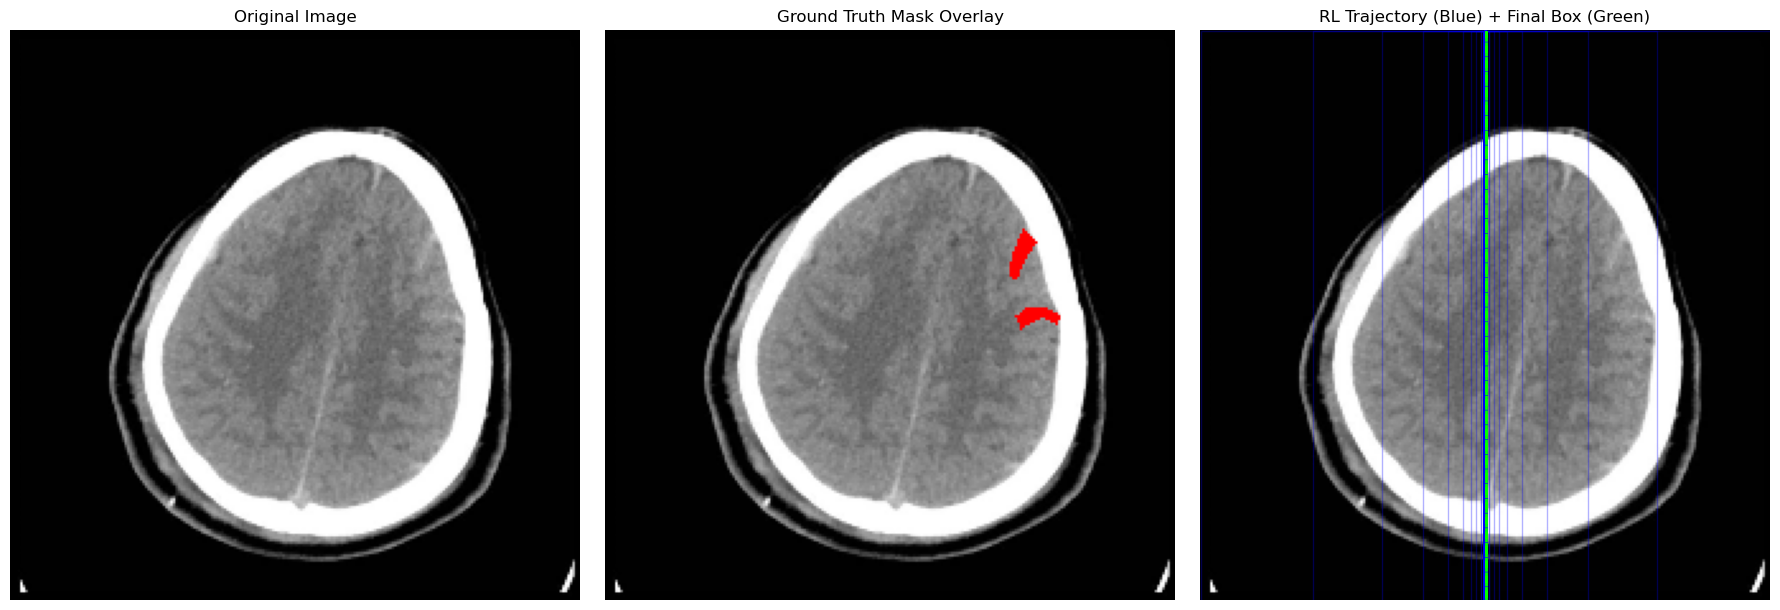

In [58]:
visualize_agent_prediction(model, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')

In [46]:
evaluate_model(model, X_test, Y_test, vgg16)

Image 0, Final IoU: 0.0000
Q-values: [-0.25008067  0.3625658   0.9445893   0.0214158   0.2550722   0.4919004
  0.6195772   0.8264746  -0.14385198]
Image 1, Final IoU: 0.0000
Q-values: [-0.14344063  0.41282314  0.9253679   0.07261958  0.27028972  0.31384918
  0.66298646  0.88825333 -0.20592767]


KeyboardInterrupt: 